## Miquel Monge Dalmau
---

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Simple Autoencoder

We will define a simple MLP Autoencoder

> **Apunts Classe**:

> Intentem recuperar les dades originals amb una representació més petita de 128. Amb el MSE comparem els valor d'entrada amb els valors de sortida reconstruïts. És un problema de regressió perquè les dades són entre 0 i 1 (escala de grisos). Si els valors fossin de 0 o 1 el loss podria ser de classificació (cross entropy). Depenent de com siguin les dades podem fer servir un looss o un altre.

> Per què a l'última capa utilitzem no linearitat sigmoidea? Estem dient al model que la sortida és entre 0 o 1. Sense sigmoidea podria funcionar també.

In [5]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x            

In [6]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [7]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))
    return loss

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader: # no utilitzem labels
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features) # es calcula la loss a partir de la sortida i la entrada
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

    return loss

epoch : 1/10, Train loss = 0.046927
epoch : 1/10, Test loss = 0.023131


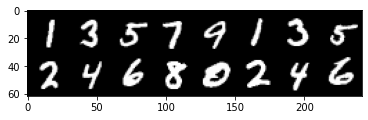

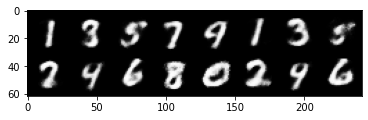

epoch : 2/10, Train loss = 0.018986
epoch : 2/10, Test loss = 0.015319


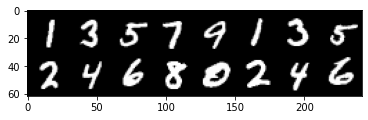

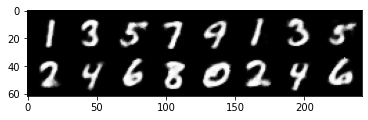

epoch : 3/10, Train loss = 0.013754
epoch : 3/10, Test loss = 0.011890


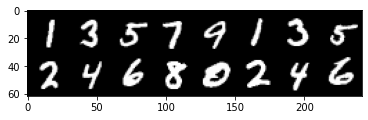

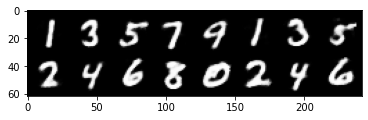

epoch : 4/10, Train loss = 0.011340
epoch : 4/10, Test loss = 0.010332


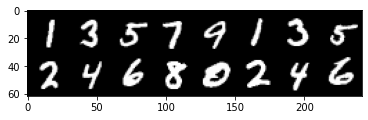

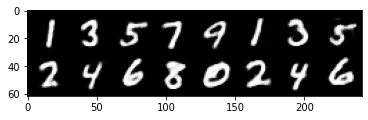

epoch : 5/10, Train loss = 0.009862
epoch : 5/10, Test loss = 0.009056


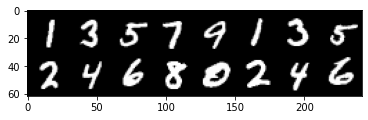

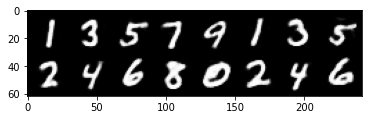

epoch : 6/10, Train loss = 0.008835
epoch : 6/10, Test loss = 0.008173


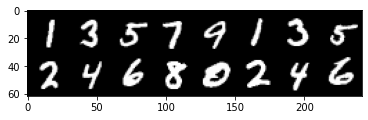

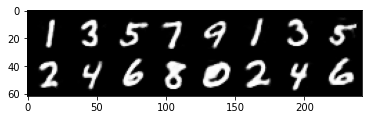

epoch : 7/10, Train loss = 0.008061
epoch : 7/10, Test loss = 0.007432


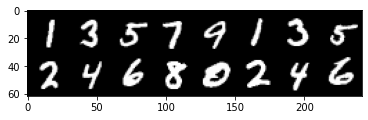

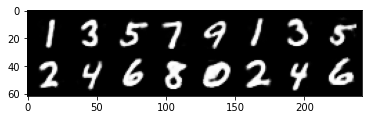

epoch : 8/10, Train loss = 0.007420
epoch : 8/10, Test loss = 0.006997


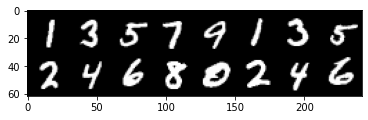

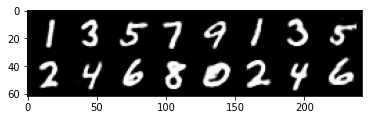

epoch : 9/10, Train loss = 0.006902
epoch : 9/10, Test loss = 0.006437


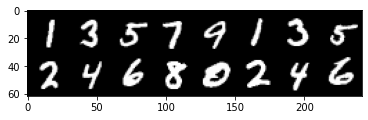

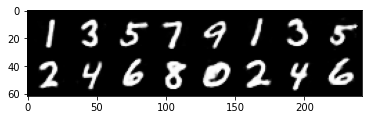

epoch : 10/10, Train loss = 0.006454
epoch : 10/10, Test loss = 0.006066


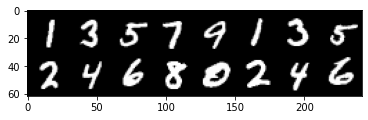

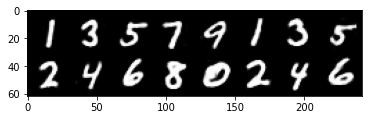

In [8]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

- Representation learning:

Un cop he entrenat al autoencoder, oblido en decorder i utilitzem el encoder com feature extractor.

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [9]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),           # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                          # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),           # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)                           # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),             # b,16,5,5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b,8,15,15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),   # b,1,28,28
            nn.Sigmoid()
      )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

epoch : 1/10, Train loss = 0.104003
epoch : 1/10, Test loss = 0.079482


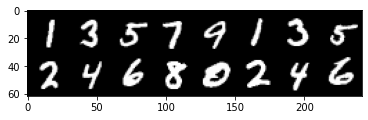

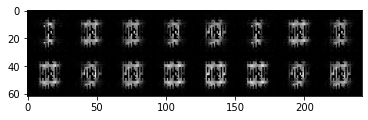

epoch : 2/10, Train loss = 0.068854
epoch : 2/10, Test loss = 0.055047


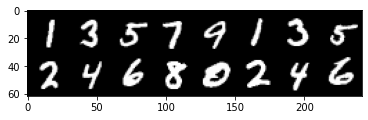

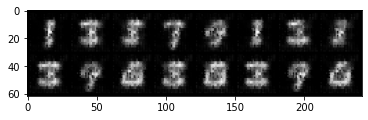

epoch : 3/10, Train loss = 0.047243
epoch : 3/10, Test loss = 0.043556


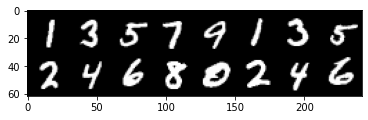

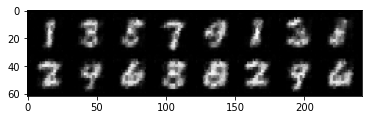

epoch : 4/10, Train loss = 0.041967
epoch : 4/10, Test loss = 0.039836


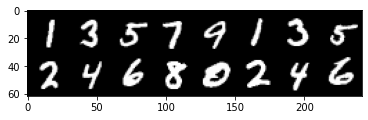

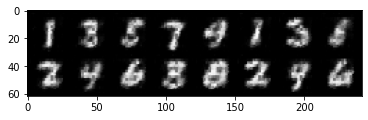

epoch : 5/10, Train loss = 0.038752
epoch : 5/10, Test loss = 0.037103


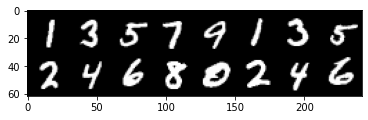

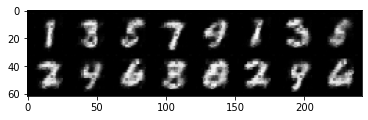

epoch : 6/10, Train loss = 0.036702
epoch : 6/10, Test loss = 0.035316


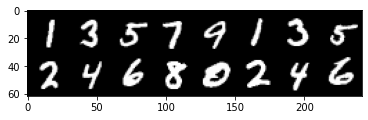

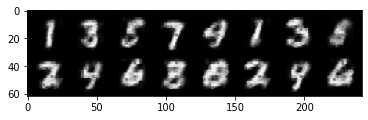

epoch : 7/10, Train loss = 0.035182
epoch : 7/10, Test loss = 0.034159


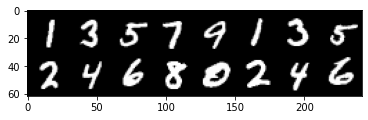

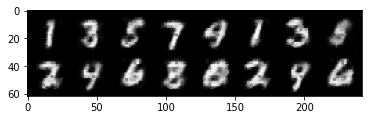

epoch : 8/10, Train loss = 0.034246
epoch : 8/10, Test loss = 0.033368


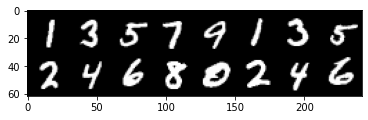

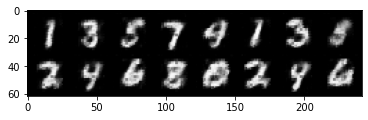

epoch : 9/10, Train loss = 0.033468
epoch : 9/10, Test loss = 0.032673


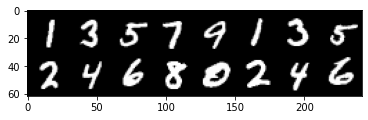

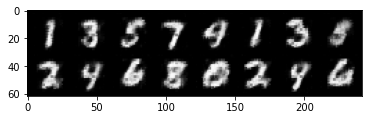

epoch : 10/10, Train loss = 0.032792
epoch : 10/10, Test loss = 0.032006


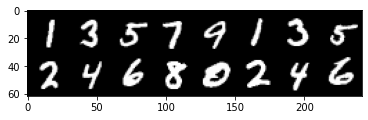

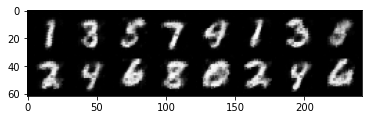

In [10]:
model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=False)
    test(model, test_loader, criterion, reshape=False) 

In [11]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4              [-1, 8, 3, 3]           1,160
              ReLU-5              [-1, 8, 3, 3]               0
         MaxPool2d-6              [-1, 8, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           1,168
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

La reconstrucció no és tan bona perquè no tenim molts paràmetres 5k. Podem augmentar a més. Tot i això, aquest mateix autoencoder amb mes epochs ho pot fer bé. L'última raó és que a la representació intermitga estem comprimint encara mes.

<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [12]:
class SymmetricAE(nn.Module):
    def __init__(self):
        super(SymmetricAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices = True)
        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=1, return_indices=True)

        # Decoder
        self.unpool1 = nn.MaxUnpool2d(2, stride = 1)
        self.unconv1 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding = 1)
        self.unpool2 = nn.MaxUnpool2d(2, stride = 2)
        self.unconv2 = nn.ConvTranspose2d(16, 1, 3, stride=3, padding=1)  

    def forward(self, x):
        # Encoder
        x = torch.relu(self.conv1(x))
        x, indices1 = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x, indices2 = self.pool2(x)

        # Decoder
        x = self.unpool1(x, indices2)
        x = torch.relu(self.unconv1(x))
        x = self.unpool2(x, indices1)
        x = torch.sigmoid(self.unconv2(x))

        return x

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


epoch : 1/10, Train loss = 0.207961
epoch : 1/10, Test loss = 0.152628


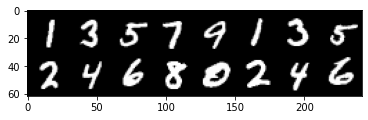

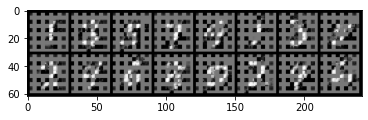

epoch : 2/10, Train loss = 0.127584
epoch : 2/10, Test loss = 0.106668


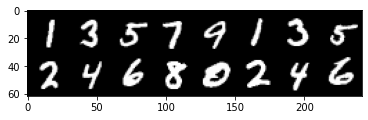

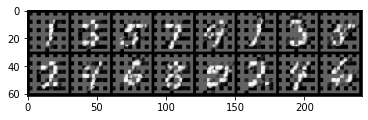

epoch : 3/10, Train loss = 0.089898
epoch : 3/10, Test loss = 0.076623


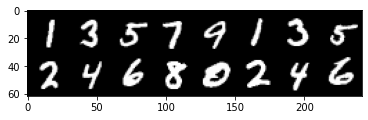

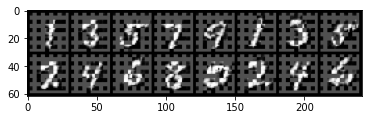

epoch : 4/10, Train loss = 0.067522
epoch : 4/10, Test loss = 0.060002


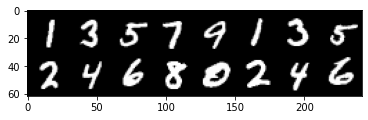

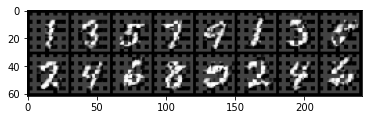

epoch : 5/10, Train loss = 0.054270
epoch : 5/10, Test loss = 0.049627


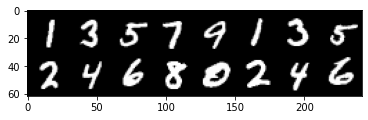

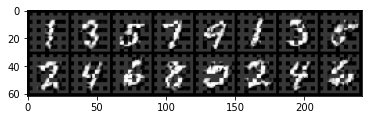

epoch : 6/10, Train loss = 0.045953
epoch : 6/10, Test loss = 0.042974


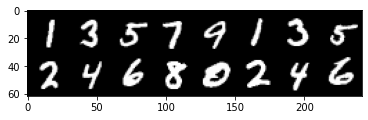

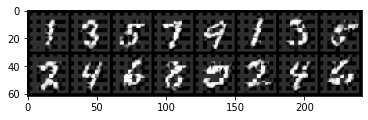

epoch : 7/10, Train loss = 0.039856
epoch : 7/10, Test loss = 0.037334


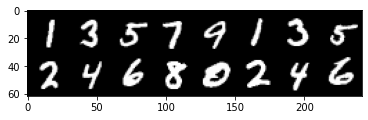

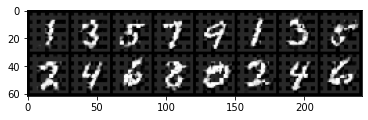

epoch : 8/10, Train loss = 0.034657
epoch : 8/10, Test loss = 0.032393


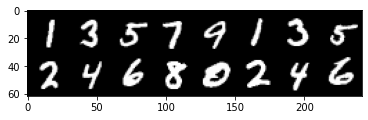

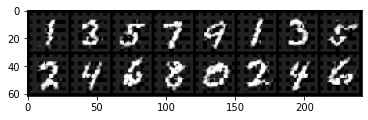

epoch : 9/10, Train loss = 0.030842
epoch : 9/10, Test loss = 0.029571


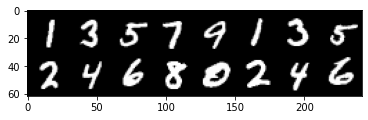

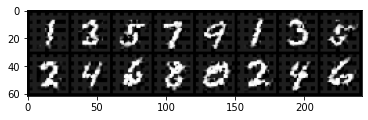

epoch : 10/10, Train loss = 0.028502
epoch : 10/10, Test loss = 0.027595


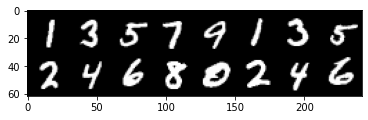

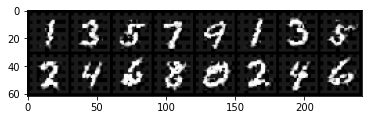

In [13]:
model = SymmetricAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=False)
    test(model, test_loader, criterion, reshape=False) 

In [14]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
         MaxPool2d-2  [[-1, 16, 5, 5], [-1, 16, 5, 5]]               0
            Conv2d-3              [-1, 8, 3, 3]           1,160
         MaxPool2d-4  [[-1, 8, 2, 2], [-1, 8, 2, 2]]               0
       MaxUnpool2d-5              [-1, 8, 3, 3]               0
   ConvTranspose2d-6             [-1, 16, 5, 5]           1,168
       MaxUnpool2d-7           [-1, 16, 10, 10]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]             145
Total params: 2,633
Trainable params: 2,633
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.19
Params size (MB): 0.01
Estimated Total Size (MB): 1.21
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

> Reparametrize:

> No té derivada per això ens inventem un truc, samplejant utilitzant la suma. Si samplejem aleatòriament tal qual (imatge power esquerra) no podem fer backprop. Per això fem això de la distribució estàndard mitjana 0 i std a 1, samplejem aquesta epsilon i la tractem com una constant. Per treure la z multipliquem la epislon per la std i sumem la mitjana de la nostra distribució. d'aquesta manera fem el mateix (en resultat) del que fèiem, però podem fer backprop, sí que tenim derivades.

In [15]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        # encoder crea la mu i la sigma
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_() # valor aleatori de distribucio normal estandart per el epsilon. aixo es el q no te derivada.
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std # ens retorna la suma operació z (equivalent a fer sampleig aleatori d distribucio normal amb std i mitjana).

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [16]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Te dues parts, reconstrucion loss i KLD: Es una formula que compara dues distribucions de prob.

    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [17]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [18]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()    
    
    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    print(batch_features.shape)
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 5787.828079
epoch : 1/10, Test loss = 1164.072834
torch.Size([16, 784])


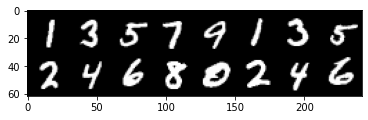

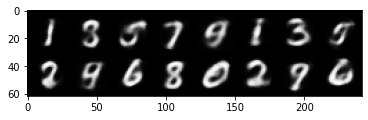

epoch : 2/10, Train loss = 4474.073231
epoch : 2/10, Test loss = 1068.328366
torch.Size([16, 784])


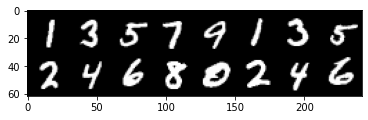

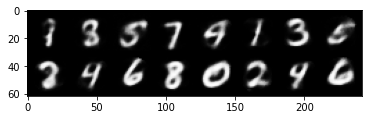

epoch : 3/10, Train loss = 4233.086883
epoch : 3/10, Test loss = 1029.468414
torch.Size([16, 784])


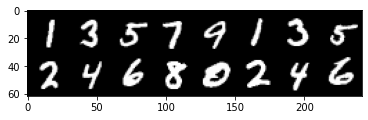

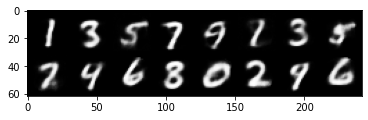

epoch : 4/10, Train loss = 4127.207927
epoch : 4/10, Test loss = 1011.520797
torch.Size([16, 784])


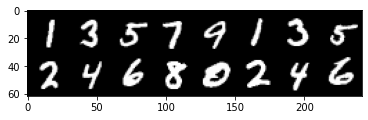

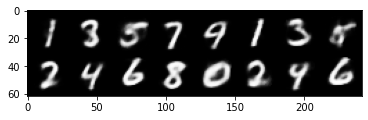

epoch : 5/10, Train loss = 4060.460989
epoch : 5/10, Test loss = 999.647793
torch.Size([16, 784])


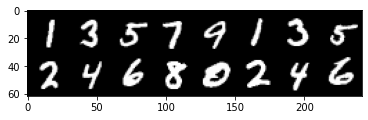

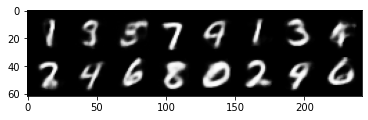

epoch : 6/10, Train loss = 4016.526314
epoch : 6/10, Test loss = 989.094375
torch.Size([16, 784])


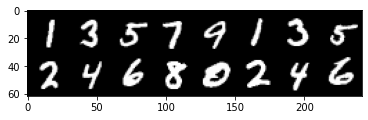

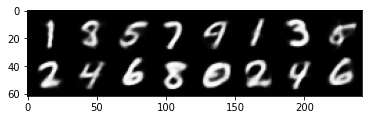

epoch : 7/10, Train loss = 3982.088481
epoch : 7/10, Test loss = 985.923566
torch.Size([16, 784])


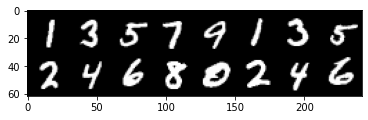

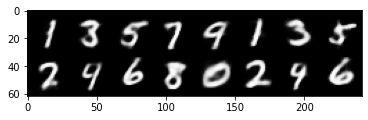

epoch : 8/10, Train loss = 3958.051211
epoch : 8/10, Test loss = 981.915335
torch.Size([16, 784])


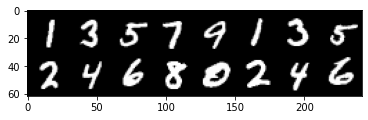

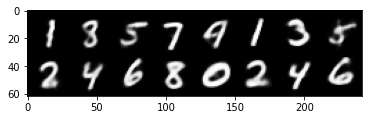

epoch : 9/10, Train loss = 3936.098718
epoch : 9/10, Test loss = 972.327320
torch.Size([16, 784])


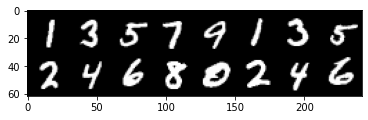

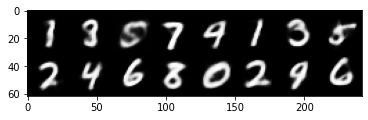

epoch : 10/10, Train loss = 3921.851840
epoch : 10/10, Test loss = 968.862023
torch.Size([16, 784])


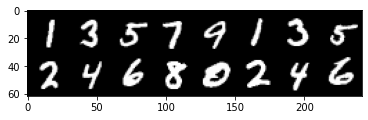

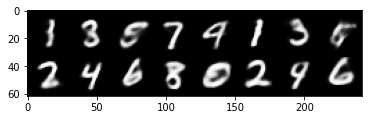

In [19]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion) 

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [20]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits
    
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])
    
        inter_image = inter_image.view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

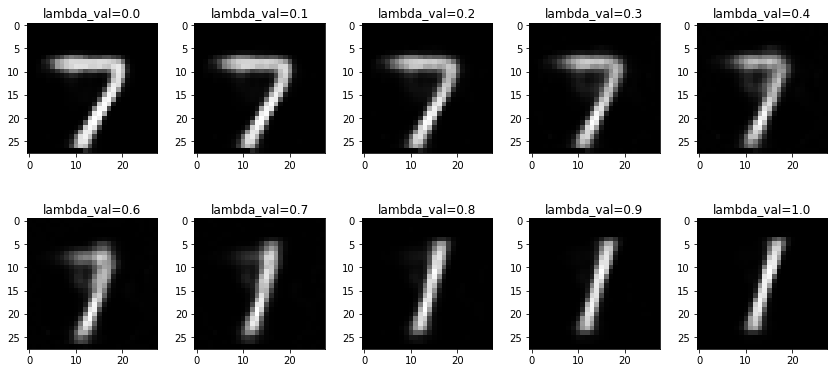

In [21]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

> Una cosa que aprèn el var autoencoder és un espai latent (latent space) on les projeccions de les z són punts en aquest espai. Amb aquesta z la passem al decoder i ens treu una imatge. Samplejem z aleatòries en aquest espai i la passem al decoder. Ens podem inventar nombres aleatoris en aquest espai de 20 dimensions i sortiran imatges que tenen sentit.

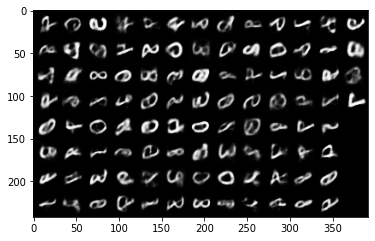

In [22]:
model.eval()
num_digits = 100

with torch.no_grad():
    # Sample from standard normal distribution
      # Returns a tensor filled with random numbers from a normal distribution
      # with mean 0 and variance 1 (also called the standard normal distribution).
    z = torch.randn(num_digits, 20, device = device)
    
    # Reconstruct images from sampled latent vectors
    recon_images = model.decode(z)    
    # Plot Generated Images
    show_image(make_grid(recon_images.detach().cpu().view(-1, 1, 28, 28)))

<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

> En lloc de d crear un espai latent de 20 dimensions crea un de 2 per poder-lo visualitzar.

In [23]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) #mu y logsigma

    def reparametrize(self, mu, logvar): #sacamos desv estandar y escalamos por la mu
        std = logvar.mul(0.5).exp_() #exponencial de la varianza entre dos
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_() #sacamos de la desv normal
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return eps.mul(std).add_(mu) #media q hemos predicho y la var con la desvnormal
        #en vez de predecir varianza preidgo log de la varianza (x calculos)

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

epoch : 1/10, Train loss = 6305.481508
epoch : 1/10, Test loss = 1382.266853
torch.Size([16, 784])


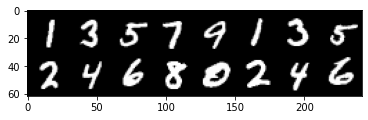

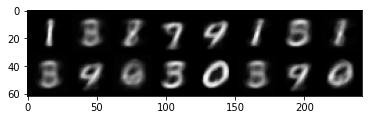

epoch : 2/10, Train loss = 5437.253009
epoch : 2/10, Test loss = 1331.733954
torch.Size([16, 784])


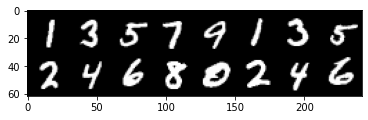

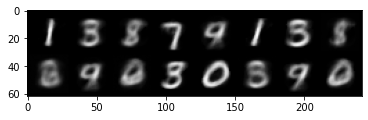

epoch : 3/10, Train loss = 5292.306978
epoch : 3/10, Test loss = 1313.752758
torch.Size([16, 784])


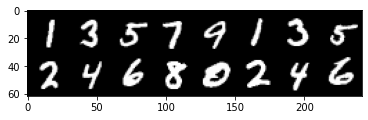

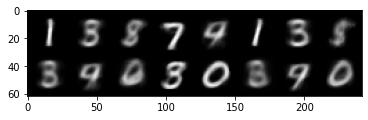

epoch : 4/10, Train loss = 5220.838087
epoch : 4/10, Test loss = 1303.996354
torch.Size([16, 784])


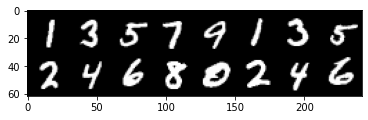

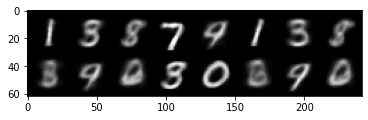

epoch : 5/10, Train loss = 5174.597131
epoch : 5/10, Test loss = 1291.436698
torch.Size([16, 784])


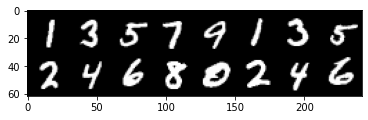

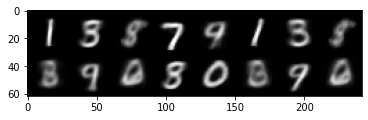

epoch : 6/10, Train loss = 5132.459953
epoch : 6/10, Test loss = 1284.144124
torch.Size([16, 784])


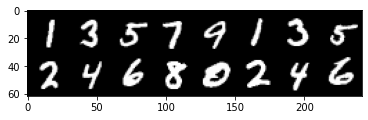

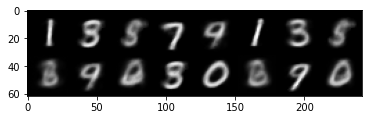

epoch : 7/10, Train loss = 5094.918281
epoch : 7/10, Test loss = 1274.021948
torch.Size([16, 784])


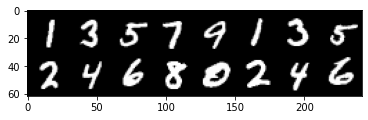

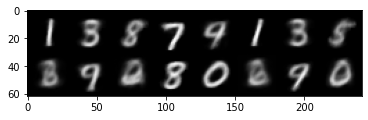

epoch : 8/10, Train loss = 5065.471010
epoch : 8/10, Test loss = 1265.996355
torch.Size([16, 784])


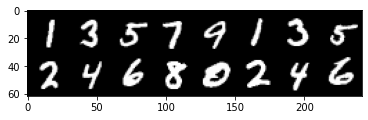

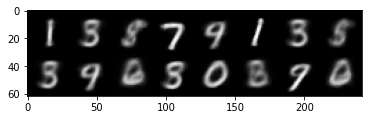

epoch : 9/10, Train loss = 5035.650967
epoch : 9/10, Test loss = 1269.671185
torch.Size([16, 784])


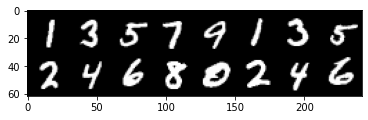

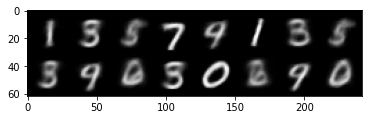

epoch : 10/10, Train loss = 5012.604168
epoch : 10/10, Test loss = 1258.138886
torch.Size([16, 784])


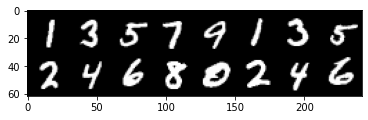

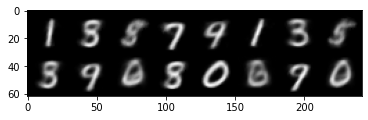

In [24]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer_d = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

epochs=10
for epoch in range(epochs):
      train_vae(model, train_loader, optimizer_d, criterion)
      test_vae(model, test_loader, criterion) 

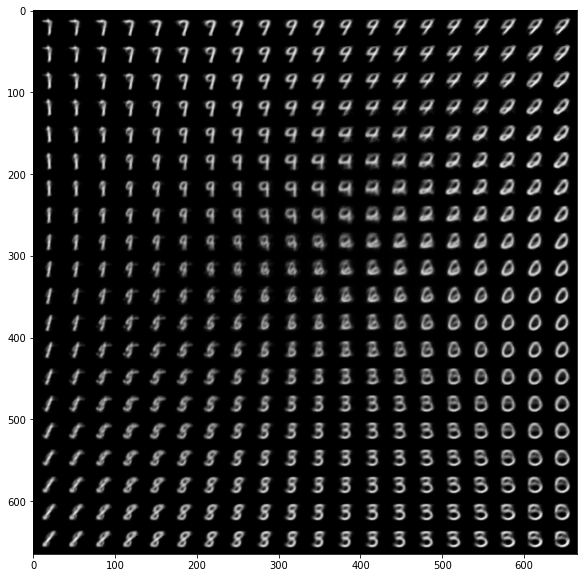

In [25]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    
    # Flatten grid into a batch
    latents = latents.view(-1, 2) 

    # Send to GPU
    latents = latents.to(device)
    # Find their representation
    image_recon = model.decode(latents).view(-1, 1, 28, 28)
    image_recon = image_recon.cpu()
    
    # Finally, plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.transpose(make_grid(image_recon.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0)))

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [26]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



epoch : 1/10, Train loss = 0.036999
epoch : 1/10, Test loss = 0.021463


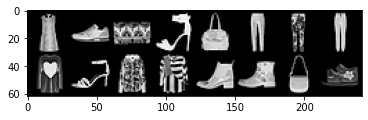

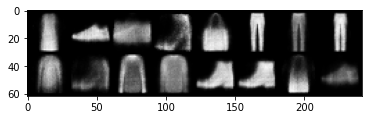

epoch : 2/10, Train loss = 0.019332
epoch : 2/10, Test loss = 0.017624


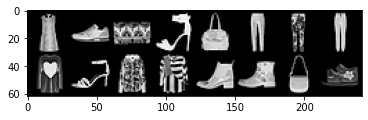

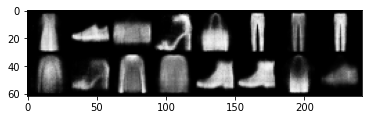

epoch : 3/10, Train loss = 0.016412
epoch : 3/10, Test loss = 0.015609


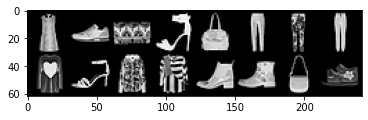

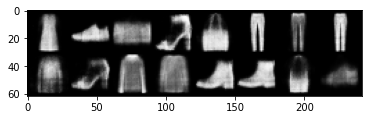

epoch : 4/10, Train loss = 0.014701
epoch : 4/10, Test loss = 0.014141


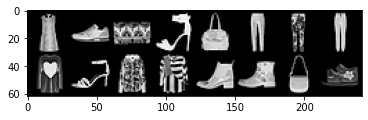

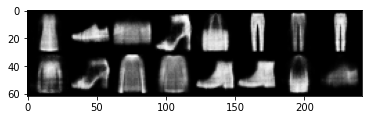

epoch : 5/10, Train loss = 0.013505
epoch : 5/10, Test loss = 0.013200


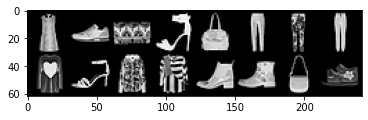

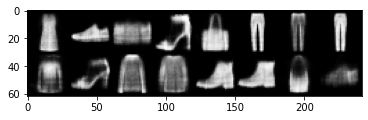

epoch : 6/10, Train loss = 0.012719
epoch : 6/10, Test loss = 0.012626


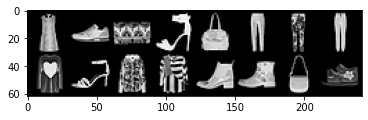

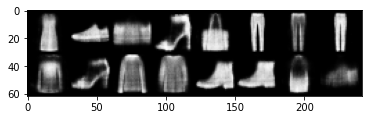

epoch : 7/10, Train loss = 0.012065
epoch : 7/10, Test loss = 0.011866


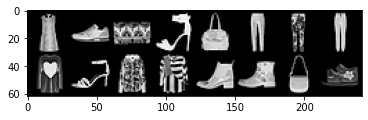

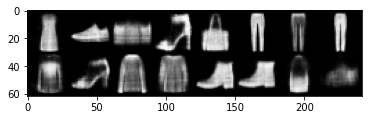

epoch : 8/10, Train loss = 0.011537
epoch : 8/10, Test loss = 0.011675


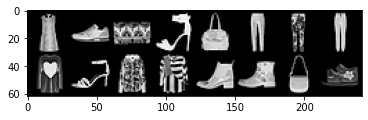

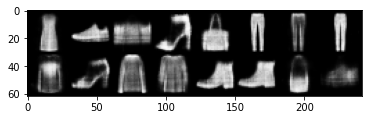

epoch : 9/10, Train loss = 0.011118
epoch : 9/10, Test loss = 0.010976


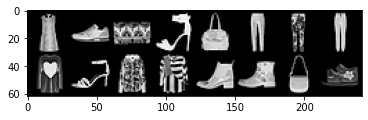

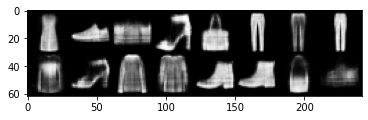

epoch : 10/10, Train loss = 0.010750
epoch : 10/10, Test loss = 0.010750


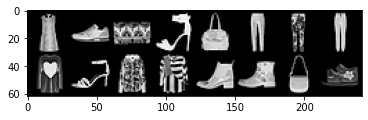

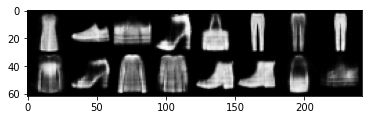

In [27]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_size = 784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs = 10
loss_AE = {"train": [], "val": []}

for epoch in range(epochs):
    loss_train = train(model, train_loader_FMNIST, optimizer, criterion, reshape=True)
    loss_test = test(model, test_loader_FMNIST, criterion, reshape=True)

    loss_AE["train"].append(loss_train)
    loss_AE["val"].append(loss_test)

epoch : 1/10, Train loss = 0.076149
epoch : 1/10, Test loss = 0.037849


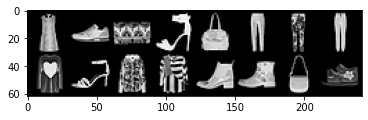

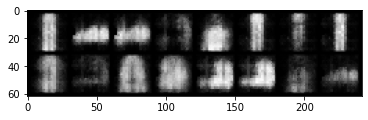

epoch : 2/10, Train loss = 0.032895
epoch : 2/10, Test loss = 0.029440


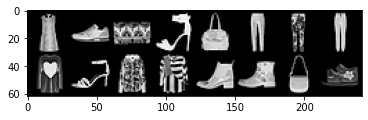

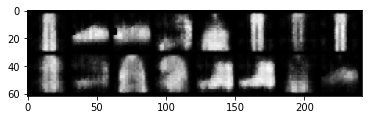

epoch : 3/10, Train loss = 0.027484
epoch : 3/10, Test loss = 0.025600


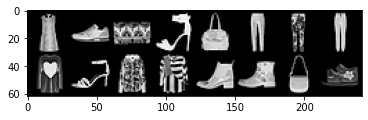

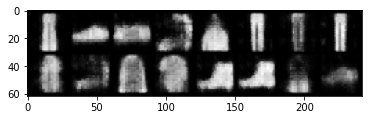

epoch : 4/10, Train loss = 0.024519
epoch : 4/10, Test loss = 0.023630


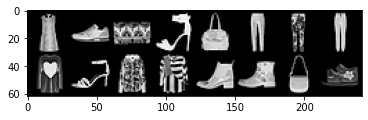

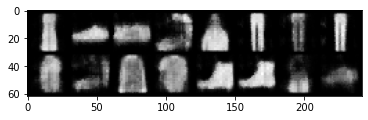

epoch : 5/10, Train loss = 0.022971
epoch : 5/10, Test loss = 0.022440


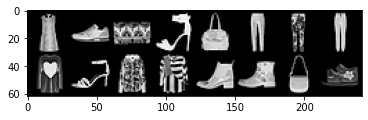

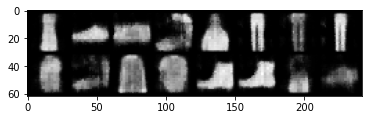

epoch : 6/10, Train loss = 0.021975
epoch : 6/10, Test loss = 0.021577


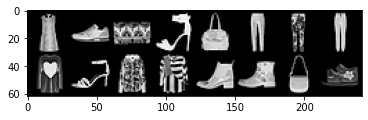

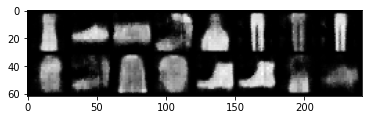

epoch : 7/10, Train loss = 0.021203
epoch : 7/10, Test loss = 0.020906


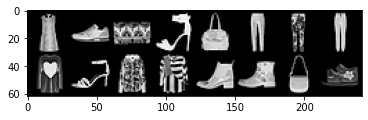

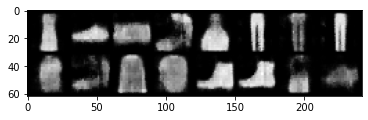

epoch : 8/10, Train loss = 0.020615
epoch : 8/10, Test loss = 0.020428


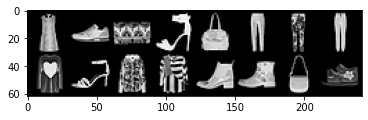

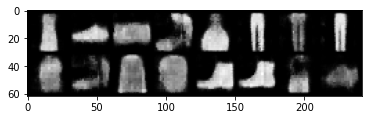

epoch : 9/10, Train loss = 0.020138
epoch : 9/10, Test loss = 0.019978


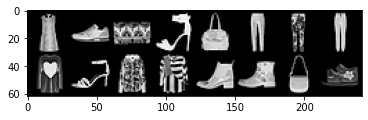

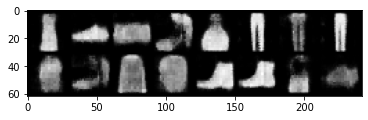

epoch : 10/10, Train loss = 0.019752
epoch : 10/10, Test loss = 0.019708


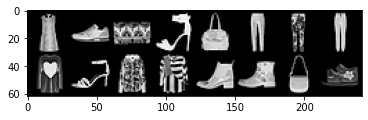

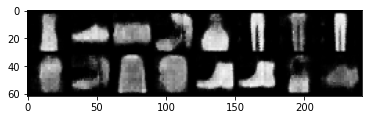

In [28]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs = 10
loss_ConvAE = {"train": [], "val": []}

for epoch in range(epochs):
    loss_train = train(model, train_loader_FMNIST, optimizer, criterion)
    loss_val = test(model, test_loader_FMNIST, criterion) 

    loss_ConvAE["train"].append(loss_train)
    loss_ConvAE["val"].append(loss_val)

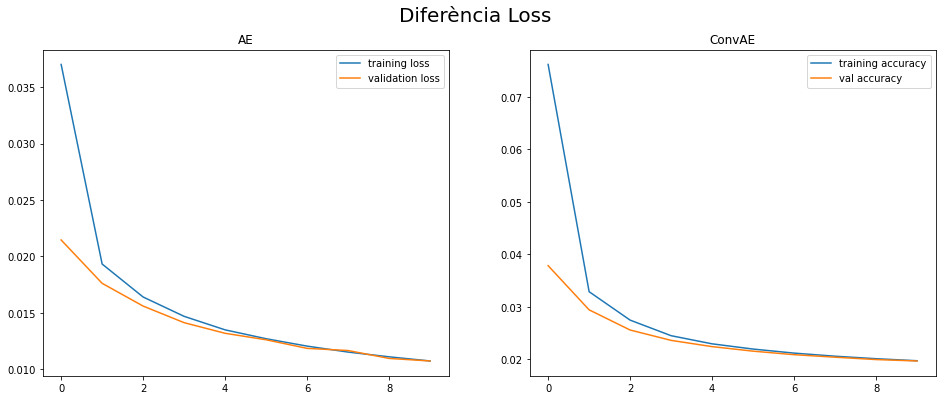

In [29]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(loss_AE["train"], label="training loss")
ax1.plot(loss_AE["val"], label="validation loss")
ax1.set_title("AE")
ax1.legend()

ax2.plot(loss_ConvAE["train"], label="training accuracy")
ax2.plot(loss_ConvAE["val"], label="val accuracy")
ax2.set_title("ConvAE")
ax2.legend()

fig.suptitle("Diferència Loss", fontsize = 20)
plt.show()   

> En aquest primer plot he decidit plotejar en cada requadre les mètriques (train, loss) per a cada model. A simple vista, els dos models són semblants, tot i que sembla que el model ConvAE aconsegueix disminuir una mica més el loss.

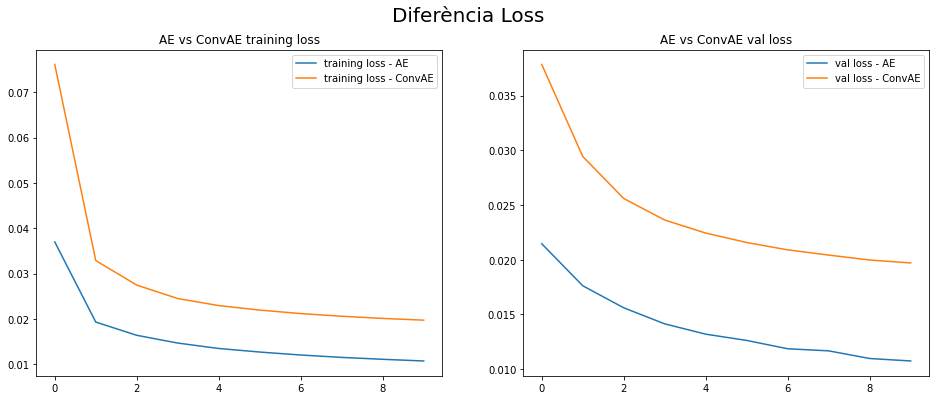

In [30]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(loss_AE["train"], label="training loss - AE")
ax1.plot(loss_ConvAE["train"], label="training loss - ConvAE")
ax1.set_title("AE vs ConvAE training loss")
ax1.legend()

ax2.plot(loss_AE["val"], label="val loss - AE")
ax2.plot(loss_ConvAE["val"], label="val loss - ConvAE")
ax2.set_title("AE vs ConvAE val loss")
ax2.legend()

fig.suptitle("Diferència Loss", fontsize = 20)
plt.show()   

> En aquest segon plot es comparen les mètriques train d'ambdós models en el requadre de l'esquerra i les mètriques del test a la dreta. En aquests plots es veu clarament com el model ConvAE aconsegueix reconstruir les dades amb una loss més petita. També ho veiem en les mateixes reconstruccions més amunt, on en aquest últim model són més clares.